In [2]:
#Useful imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, asin, acos, atan
%reload_ext autoreload
%autoreload 2
plt.style.use('latex.mplstyle')

## Load and visualize data

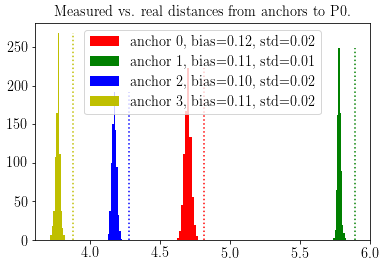

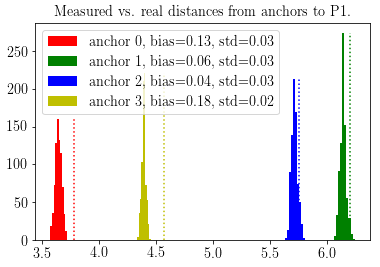

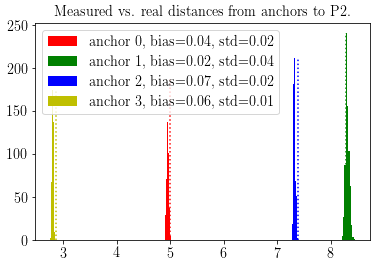

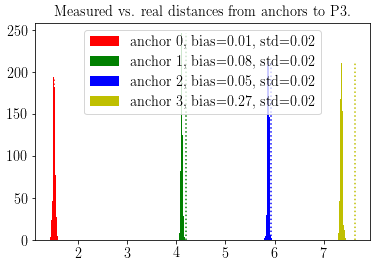

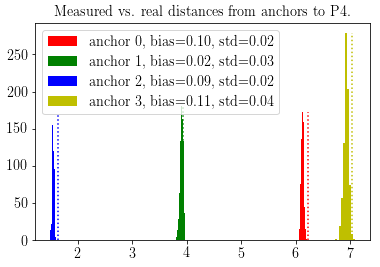

In [40]:
path = 'data/Static/'
anchors_full = np.genfromtxt(path+'anchors_EPFL.csv', delimiter=',')
anchors = anchors_full[:,1:]
real_full = np.genfromtxt(path+'data_EPFL.csv', delimiter=',')
real = real_full[:,1:]
n_positions = 5
N = anchors.shape[0]+1 

distances_all_points = []

colors = ['r','g','b','y','c']
for i in range(n_positions):
    data = np.genfromtxt(path+'pozyx_data_P{}.csv'.format(i), delimiter=',')
    P_i = real[i,:]
    id_i = int(real_full[i,0])
    
    idx_i = data[:,1] == id_i
    # Get samples corresponding to all pairs.
    distances_per_point  = []
    
    fig = plt.figure()
    #fig.set_fig(20)
    for j,a in enumerate(anchors_full):
        axs = fig.add_subplot(1,1,1)
        #axs = fig.add_subplot(1,len(anchors_full),j+1)
        P_a = a[1:]
        id_a = int(a[0])
        idx_a = data[:,2] == id_a 
        distance_real = np.linalg.norm(P_a - P_i)
        distances_ia = data[idx_a & idx_i, -1]
        
        bias = abs(distance_real - np.mean(distances_ia))
        std = np.std(distances_ia)
        
        distances_per_point.append(distances_ia)
        vals, bins, __ = axs.hist(distances_ia, label='anchor {}, bias={:2.2f}, std={:2.2f}'.format(j,bias,std),color=colors[j])
        ymax = max(vals)
        axs.vlines(distance_real, 0, ymax,color=colors[j], linestyle=':')
        plt.legend(loc='best')
    plt.title('Measured vs. real distances from anchors to P{}.'.format(i))
    plt.show()
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #bp = ax.boxplot(distances_per_point)
    #ax.set_xlabel('Anchor Id')
    #ax.set_ylabel('Distance [m]')
    #ax.set_xticklabels(anchors_full[:,0].astype('int').astype('str'))
    #ax.set_title('Point {}: {}, id={}'.format(i,P_i,id_i))
    #plt.show()
    distances_all_points.append(distances_per_point)

## Apply algorithms

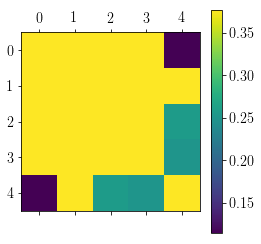

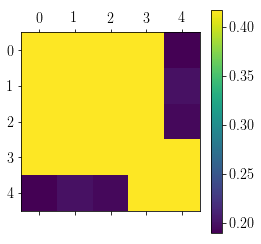

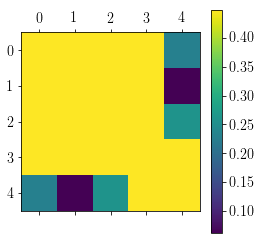

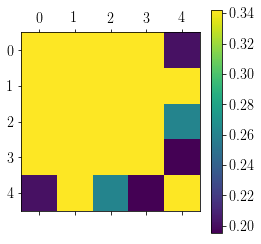

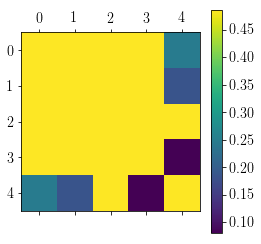

In [43]:
from point_configuration import HeterogenousConfiguration, PointConfiguration, dm_from_edm, create_from_points, edm_from_dm
from algorithms import reconstruct_mds, reconstruct_srls, reconstruct_weighted
    
d = 3
n_positions=5

points_mds = []
points_mds_weighted = []
points_srls = []
points_srls_weighted = []
points_original = []

printout=False

for i in range(n_positions):
#for i in range(1):
    P_i = real[i,:]
    real_points = np.r_[anchors,P_i.reshape((1,-1))]
    porig = create_from_points(real_points, HeterogenousConfiguration)
    index = porig.N-1
    other = np.delete(np.arange(porig.N),index)
    
    distances_per_point = distances_all_points[i]
    dist = [np.mean(d) for d in distances_per_point]
    r2 = np.power(dist,2)
    
    pnoisy = porig.copy()
    pnoisy.edm[:,index] = np.insert(r2, index, 0)
    pnoisy.edm[index,:] = np.insert(r2, index, 0)
    dm = dm_from_edm(pnoisy.edm) 

    # Add weights based on bias
    #weights = np.abs(porig.edm[-1,:-1] - r2)
    #print('weights:',weights)
    
    # Add weights based on sigma
    weights = [np.power(np.std(d),-2) for d in distances_per_point]  
    weights /= sum(weights)
    
    weights_matrix = np.ones((N,N))*max(weights)
    weights_matrix[index,other] = weights
    weights_matrix[other,index] = weights
    plt.matshow(weights_matrix)
    plt.colorbar()
    plt.show()
    
    # Add LOESS weights
    #max_dik = np.max(pnoisy.edm,axis=1)**(0.5)
    #max_dkj = np.max(pnoisy.edm,axis=0)**(0.5)
    #weights_matrix = np.ones((N,N))
    #for i in range(N):
    #    for j in range(N):
    #        hij = max(max_dik[i],max_dkj[j])
    #        weights_matrix[i,j] = np.exp(-pnoisy.edm[i,j]/hij**2)
    #plt.matshow(weights_matrix)
    #plt.colorbar()
    #plt.show()
    #weights = weights_matrix[other,index]
    #print(weights)
    
    Xmds = reconstruct_mds(dm, porig.points, False, 'geometric')
    Xmds_weighted, __, __, __ = reconstruct_weighted(pnoisy.edm, weights_matrix, porig.points, Xmds, porig.points, False)
    Xsrls = reconstruct_srls(r2, porig.points, False)
    Xsrls_weighted = reconstruct_srls(r2, porig.points, False, weights=weights)
    
    pmds = create_from_points(Xmds, PointConfiguration)
    pmds_weighted = create_from_points(Xmds_weighted, PointConfiguration)
    psrls = create_from_points(Xsrls, PointConfiguration)
    psrls_weighted = create_from_points(Xsrls_weighted, PointConfiguration)
    if (printout):
        print('Noisy edm error',np.linalg.norm(pnoisy.edm-porig.edm))
        print('SRLS edm error',np.linalg.norm(psrls.edm-porig.edm))
        print('MDS edm error ',np.linalg.norm(pmds.edm-porig.edm))
        plt.matshow(porig.edm-psrls.edm)
        plt.colorbar()
        plt.axis('off')
        plt.title('Diff SRLS {}'.format(i))
        plt.show()
        plt.matshow(porig.edm-pmds.edm)
        plt.colorbar()
        plt.axis('off')
        plt.title('Diff MDS {}'.format(i))
        plt.show()
    
    points_original.append(porig.points)
    points_mds.append(Xmds)
    points_mds_weighted.append(Xmds_weighted)
    points_srls.append(Xsrls)
    points_srls_weighted.append(Xsrls_weighted.copy())

## 2D Visualization

rmse mds 0.17614402262738998
rmse mds weighted 0.1354233173300017
rmse srls 0.2028143304642516
rmse srls weighted 0.19198432688666575


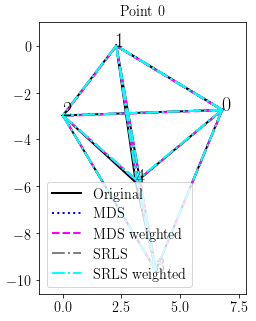

rmse mds 0.23170631379700102
rmse mds weighted 0.06899828466837375
rmse srls 0.2274568076708455
rmse srls weighted 0.23760028548451292


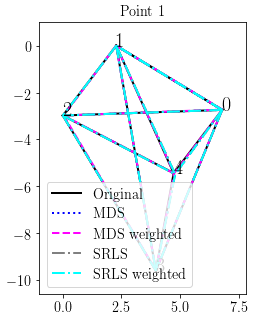

rmse mds 0.9263142348946207
rmse mds weighted 0.02727556383639412
rmse srls 0.9274260757824668
rmse srls weighted 0.9270207596189324


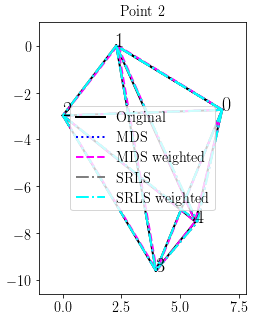

rmse mds 0.14182934087856838
rmse mds weighted 0.09511301958966421
rmse srls 0.15253881393851484
rmse srls weighted 0.16044910750681293


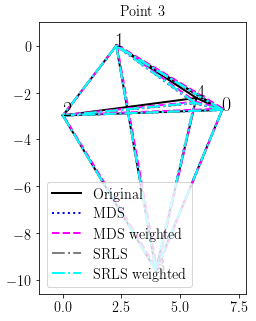

rmse mds 0.11496525859573907
rmse mds weighted 0.06375356095288974
rmse srls 0.11569177591510262
rmse srls weighted 0.11780736660230147


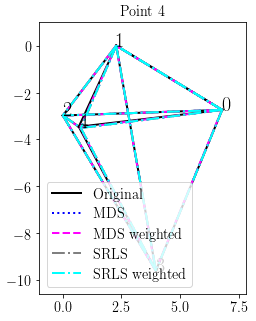

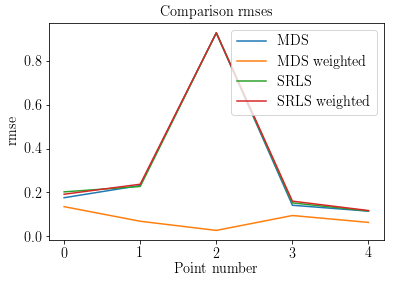

In [44]:
from plots_cti import plot_point_sets
from basics import rmse

n_methods = 4
names=['Original','MDS','MDS weighted','SRLS','SRLS weighted']
rmses = np.zeros((n_methods, n_positions))
size = [5,5]
for i in range(n_positions):
    Xorig = points_original[i]
    Xmds = points_mds[i]
    Xmds_weighted = points_mds_weighted[i]
    Xsrls = points_srls[i]
    Xsrls_weighted = points_srls_weighted[i]
    rmse_mds = rmse(Xmds[-1,:], Xorig[-1,:])
    rmse_srls = rmse(Xsrls[-1,:], Xorig[-1,:])
    rmse_srls_weighted = rmse(Xsrls_weighted[-1,:], Xorig[-1,:])
    rmse_mds_weighted = rmse(Xmds_weighted[-1,:], Xorig[-1,:])
    
    rmses[:,i] = [rmse_mds, rmse_mds_weighted, rmse_srls, rmse_srls_weighted]
    print('rmse mds', rmse_mds)
    print('rmse mds weighted', rmse_mds_weighted)
    print('rmse srls', rmse_srls)
    print('rmse srls weighted', rmse_srls_weighted)
    
    plot_point_sets([Xorig,Xmds,Xmds_weighted,Xsrls,Xsrls_weighted],'Point {}'.format(i),size=size,names=names)
    #plot_points(Xsrls, title='SRLS, rmse={:2.2e}'.format(rmse_slrs), size=size)
    #plot_points(Xmds, title='MDS, rmse={:2.2e}'.format(rmse_mds),size=size)
    
for i,method in enumerate(rmses):
    plt.plot(method,label=names[i+1])
plt.legend(loc='best')
plt.xlabel('Point number')
plt.ylabel('rmse')
plt.title('Comparison rmses')
plt.show()

## 3D Visualization

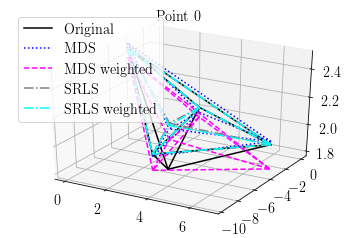

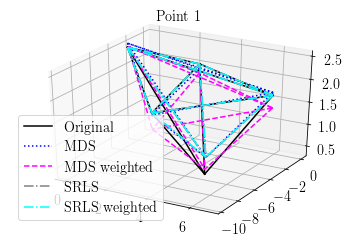

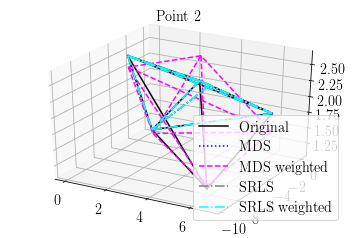

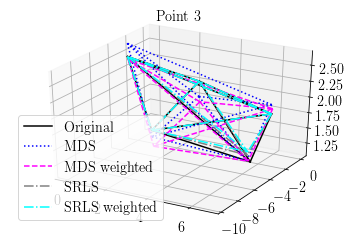

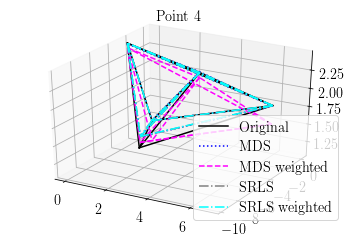

In [38]:
from plots_cti import plot_point_sets_3d

for i in range(n_positions):
    Xorig = points_original[i]
    Xmds = points_mds[i]
    Xsrls = points_srls[i]
    Xmds_weighted = points_mds_weighted[i]
    Xsrls_weighted = points_srls_weighted[i]
    plot_points = [Xorig, Xmds, Xmds_weighted, Xsrls, Xsrls_weighted]
    plot_point_sets_3d(plot_points, names, 'Point {}'.format(i))